# House-Pricess Project

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Evaluation
### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)


- [Competition Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)


## Obervartions
- No vamos a trabajar Outliers para una primera version
- No vamos a estandarizar para una primera version
- Los nulos se van a trabajar de forma simple

# Imports and reading the data

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Para el análisis de multicolinealidad (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Functions

In [80]:
# Functions
def overview_features(df):
    for col in df.columns:
        print(f"\n{col}:")
        print(f"  Nulos: {df[col].isnull().sum()}")
        print(f"  Tipo: {df[col].dtype}")
        print(f"  Valores únicos: {df[col].nunique()}")
        print(f"  Valores lista: {df[col].unique().tolist()}")
        


In [81]:
def analizar_todas_variables(X, y):
    """
    Analiza todas las columnas numéricas y clasifica por tipo
    """
    resultados = {}
    
    for col in X.select_dtypes(include=[np.number]).columns:
        pearson = pearsonr(X[col], y)[0]
        spearman = spearmanr(X[col], y)[0]
        diff = abs(spearman - pearson)
        
        if diff < 0.05:
            tipo = 'Lineal'
        elif diff < 0.15:
            tipo = 'Verificar'
        else:
            tipo = 'No-lineal'
        
        resultados[col] = {
            'Pearson': pearson,
            'Spearman': spearman,
            'Diff': diff,
            'Tipo': tipo
        }
    
    # Crear DataFrame ordenado por diferencia
    df_resultados = pd.DataFrame(resultados).T
    df_resultados = df_resultados.sort_values('Diff', ascending=False)
    
    print("\n=== ANÁLISIS DE LINEALIDAD ===")
    print(df_resultados.round(3))
    
    # Resumen
    lineales = df_resultados[df_resultados['Tipo'] == 'Lineal'].index.tolist()
    no_lineales = df_resultados[df_resultados['Tipo'] == 'No-lineal'].index.tolist()
    verificar = df_resultados[df_resultados['Tipo'] == 'Verificar'].index.tolist()
    
    print(f"\n✅ LINEALES ({len(lineales)}): {lineales}")
    print(f"🚨 NO-LINEALES ({len(no_lineales)}): {no_lineales}")
    print(f"⚠️ VERIFICAR VISUALMENTE ({len(verificar)}): {verificar}")
    
    return df_resultados

In [82]:
def visualizar_categorica(df, col, target=None):
    if target:
        # Relación con target (promedio por categoría)
        df.groupby(col)[target].mean().sort_values().plot(kind='barh')
        plt.xlabel(f'Promedio de {target}')
    else:
        # Distribución de categorías
        df[col].value_counts().plot(kind='barh')
        plt.xlabel('Frecuencia')
    
    plt.ylabel(col)
    plt.title(f'Análisis de {col}')
    plt.tight_layout()
    plt.show()

In [83]:
def boxplot_categorica(df, cat_col, target):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=cat_col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{cat_col} vs {target}')
    plt.tight_layout()
    plt.show()

In [84]:
def visualizar_continua(df, col, target=None):
    if target:
        # Relación con target
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.scatter(df[col], df[target], alpha=0.5)
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f'{col} vs {target}')
        
        plt.subplot(1, 2, 2)
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Distribución de {col}')
        
        plt.tight_layout()
        plt.show()
    else:
        # Solo distribución
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Distribución de {col}')
        plt.show()

### Read the data

In [85]:
ds_base_train = pd.read_csv("data/train.csv")
ds_base_test = pd.read_csv("data/test.csv")

In [86]:
ds_base_train.shape
print(f"Columns: {ds_base_train.shape[1]} \nRows: {ds_base_train.shape[0]}")

Columns: 81 
Rows: 1460


In [87]:
ds_base_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [88]:
ds_base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [89]:
overview_features(ds_base_train)


Id:
  Nulos: 0
  Tipo: int64
  Valores únicos: 1460
  Valores lista: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

In [90]:
# Analisis de linealidad antes de transformaciones
analizar_todas_variables(ds_base_train, ds_base_train['SalePrice'])


=== ANÁLISIS DE LINEALIDAD ===
                Pearson  Spearman      Diff       Tipo
LotArea        0.263843  0.456461  0.192617  No-lineal
OpenPorchSF    0.315856  0.477561  0.161704  No-lineal
YearBuilt      0.522897  0.652682  0.129784  Verificar
MSSubClass    -0.084284  0.007192  0.091476  Verificar
EnclosedPorch -0.128578 -0.218394  0.089816  Verificar
BsmtFinSF1      0.38642  0.301871  0.084549  Verificar
FullBath       0.560664  0.635957  0.075293  Verificar
BedroomAbvGr   0.168213  0.234907  0.066694  Verificar
YearRemodAdd   0.507101  0.571159  0.064058  Verificar
HalfBath       0.284108  0.343008    0.0589  Verificar
Fireplaces     0.466929  0.519247  0.052319  Verificar
OverallCond   -0.077856 -0.129325  0.051469  Verificar
GarageCars     0.640409  0.690711  0.050302  Verificar
LowQualFinSF  -0.025606 -0.067719  0.042113     Lineal
MiscVal        -0.02119 -0.062727  0.041537     Lineal
PoolArea       0.092404  0.058453  0.033951     Lineal
1stFlrSF       0.605852  0.575408

,Pearson,Spearman,Diff,Tipo
LotArea,0.263843,0.456461,0.192617,No-lineal
OpenPorchSF,0.315856,0.477561,0.161704,No-lineal
YearBuilt,0.522897,0.652682,0.129784,Verificar
MSSubClass,-0.084284,0.007192,0.091476,Verificar
EnclosedPorch,-0.128578,-0.218394,0.089816,Verificar
BsmtFinSF1,0.38642,0.301871,0.084549,Verificar
FullBath,0.560664,0.635957,0.075293,Verificar
BedroomAbvGr,0.168213,0.234907,0.066694,Verificar
YearRemodAdd,0.507101,0.571159,0.064058,Verificar
HalfBath,0.284108,0.343008,0.0589,Verificar


# Analisis Exploratorio de Variables

En esta seccion vamos a analizar todas las variables del dataset para entender:
- Cuantas variables numericas y categoricas tenemos
- Cuales tienen valores nulos y en que proporcion
- La distribucion de la variable objetivo (SalePrice)

In [91]:
# ============================================
# RESUMEN DE TIPOS DE VARIABLES Y VALORES NULOS
# ============================================

# Separamos las variables por tipo (numericas vs categoricas)
# Esto es importante porque cada tipo requiere un tratamiento diferente

# Variables numericas: se pueden aplicar operaciones matematicas
num_cols = ds_base_train.select_dtypes(include=[np.number]).columns.tolist()

# Variables categoricas: representan categorias o grupos
cat_cols = ds_base_train.select_dtypes(include=['object']).columns.tolist()

print("=" * 50)
print("RESUMEN DE VARIABLES")
print("=" * 50)
print(f"\nTotal de variables: {ds_base_train.shape[1]}")
print(f"Variables numericas: {len(num_cols)}")
print(f"Variables categoricas: {len(cat_cols)}")

# Analisis de valores nulos
# Los nulos son importantes porque pueden afectar el entrenamiento del modelo
print("\n" + "=" * 50)
print("ANALISIS DE VALORES NULOS")
print("=" * 50)

# Creamos un DataFrame con el resumen de nulos
nulos_df = pd.DataFrame({
    'Variable': ds_base_train.columns,
    'Nulos': ds_base_train.isnull().sum().values,
    'Porcentaje': (ds_base_train.isnull().sum().values / len(ds_base_train) * 100).round(2),
    'Tipo': ds_base_train.dtypes.values
})

# Filtramos solo las variables con nulos y ordenamos de mayor a menor
nulos_df = nulos_df[nulos_df['Nulos'] > 0].sort_values('Nulos', ascending=False)
print(f"\nVariables con valores nulos: {len(nulos_df)} de {ds_base_train.shape[1]}")
print("\n", nulos_df.to_string(index=False))

RESUMEN DE VARIABLES

Total de variables: 81
Variables numericas: 38
Variables categoricas: 43

ANALISIS DE VALORES NULOS

Variables con valores nulos: 19 de 81

     Variable  Nulos  Porcentaje    Tipo
      PoolQC   1453       99.52  object
 MiscFeature   1406       96.30  object
       Alley   1369       93.77  object
       Fence   1179       80.75  object
  MasVnrType    872       59.73  object
 FireplaceQu    690       47.26  object
 LotFrontage    259       17.74 float64
  GarageType     81        5.55  object
 GarageYrBlt     81        5.55 float64
GarageFinish     81        5.55  object
  GarageQual     81        5.55  object
  GarageCond     81        5.55  object
BsmtFinType2     38        2.60  object
BsmtExposure     38        2.60  object
BsmtFinType1     37        2.53  object
    BsmtCond     37        2.53  object
    BsmtQual     37        2.53  object
  MasVnrArea      8        0.55 float64
  Electrical      1        0.07  object


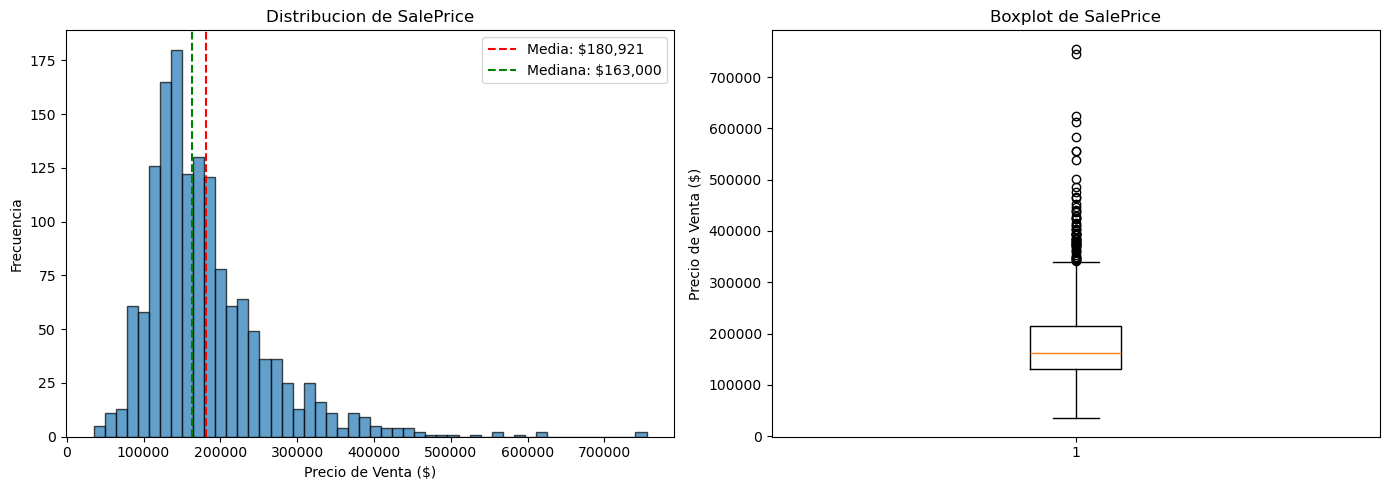


Estadisticas de SalePrice:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [92]:
# ============================================
# VISUALIZACION DE LA VARIABLE OBJETIVO (SalePrice)
# ============================================

# SalePrice es lo que queremos predecir
# Es importante entender su distribucion antes de modelar

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de SalePrice
# Muestra como se distribuyen los precios de las casas
axes[0].hist(ds_base_train['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Precio de Venta ($)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribucion de SalePrice')
axes[0].axvline(ds_base_train['SalePrice'].mean(), color='red', linestyle='--', label=f'Media: ${ds_base_train["SalePrice"].mean():,.0f}')
axes[0].axvline(ds_base_train['SalePrice'].median(), color='green', linestyle='--', label=f'Mediana: ${ds_base_train["SalePrice"].median():,.0f}')
axes[0].legend()

# Boxplot de SalePrice
# Muestra la distribucion y posibles outliers
axes[1].boxplot(ds_base_train['SalePrice'], vert=True)
axes[1].set_ylabel('Precio de Venta ($)')
axes[1].set_title('Boxplot de SalePrice')

plt.tight_layout()
plt.show()

# Estadisticas descriptivas
print("\nEstadisticas de SalePrice:")
print(ds_base_train['SalePrice'].describe())

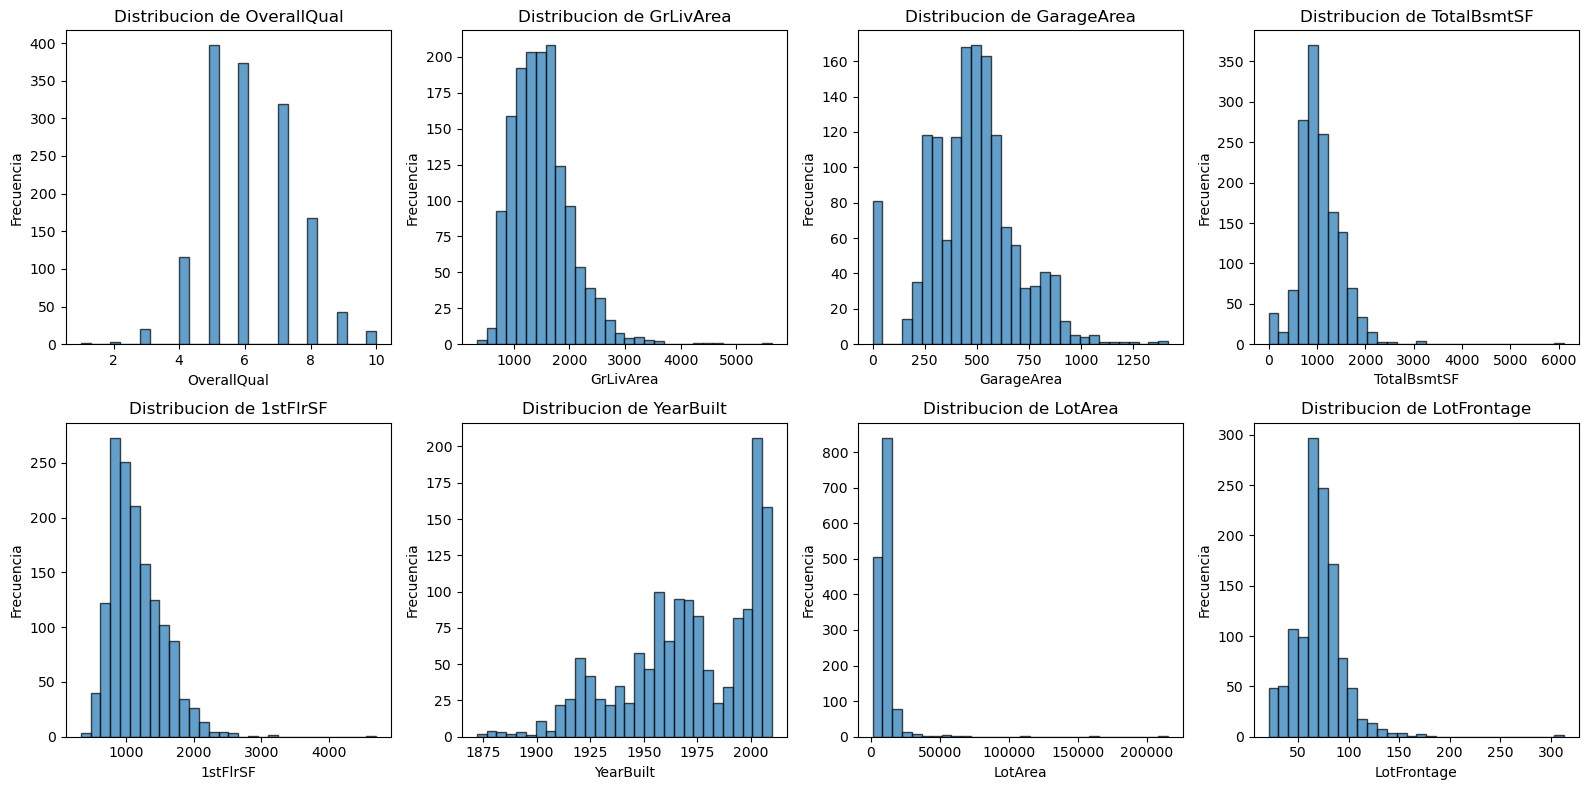

In [93]:
# ============================================
# VISUALIZACION DE VARIABLES NUMERICAS CLAVE
# ============================================

# Seleccionamos las variables numericas mas importantes para visualizar
# (excluyendo Id y SalePrice)
vars_num_plot = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 
                 '1stFlrSF', 'YearBuilt', 'LotArea', 'LotFrontage']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(vars_num_plot):
    # Histograma para cada variable numerica
    axes[i].hist(ds_base_train[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

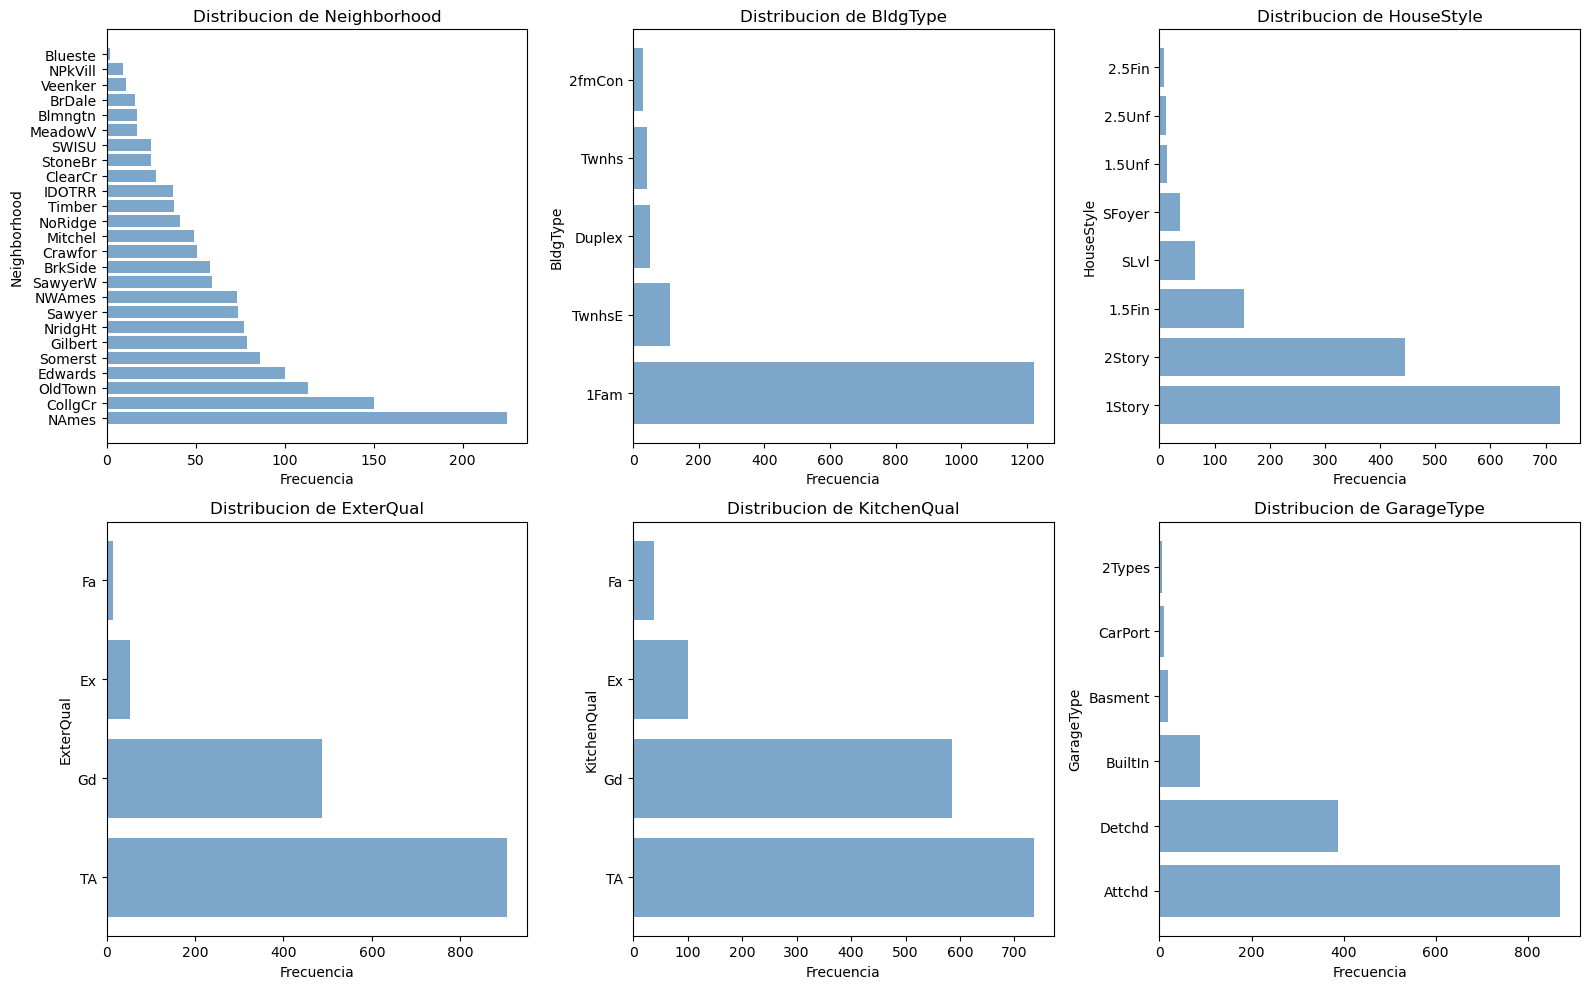

In [94]:
# ============================================
# VISUALIZACION DE VARIABLES CATEGORICAS CLAVE
# ============================================

# Seleccionamos algunas variables categoricas importantes
vars_cat_plot = ['Neighborhood', 'BldgType', 'HouseStyle', 'ExterQual', 
                 'KitchenQual', 'GarageType']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(vars_cat_plot):
    # Conteo de frecuencias por categoria
    value_counts = ds_base_train[col].value_counts()
    axes[i].barh(value_counts.index, value_counts.values, color='steelblue', alpha=0.7)
    axes[i].set_xlabel('Frecuencia')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

# Analisis de Correlacion

La correlacion nos ayuda a entender:
- Que variables tienen mayor relacion con SalePrice (nuestro target)
- Que variables estan relacionadas entre si (posible multicolinealidad)

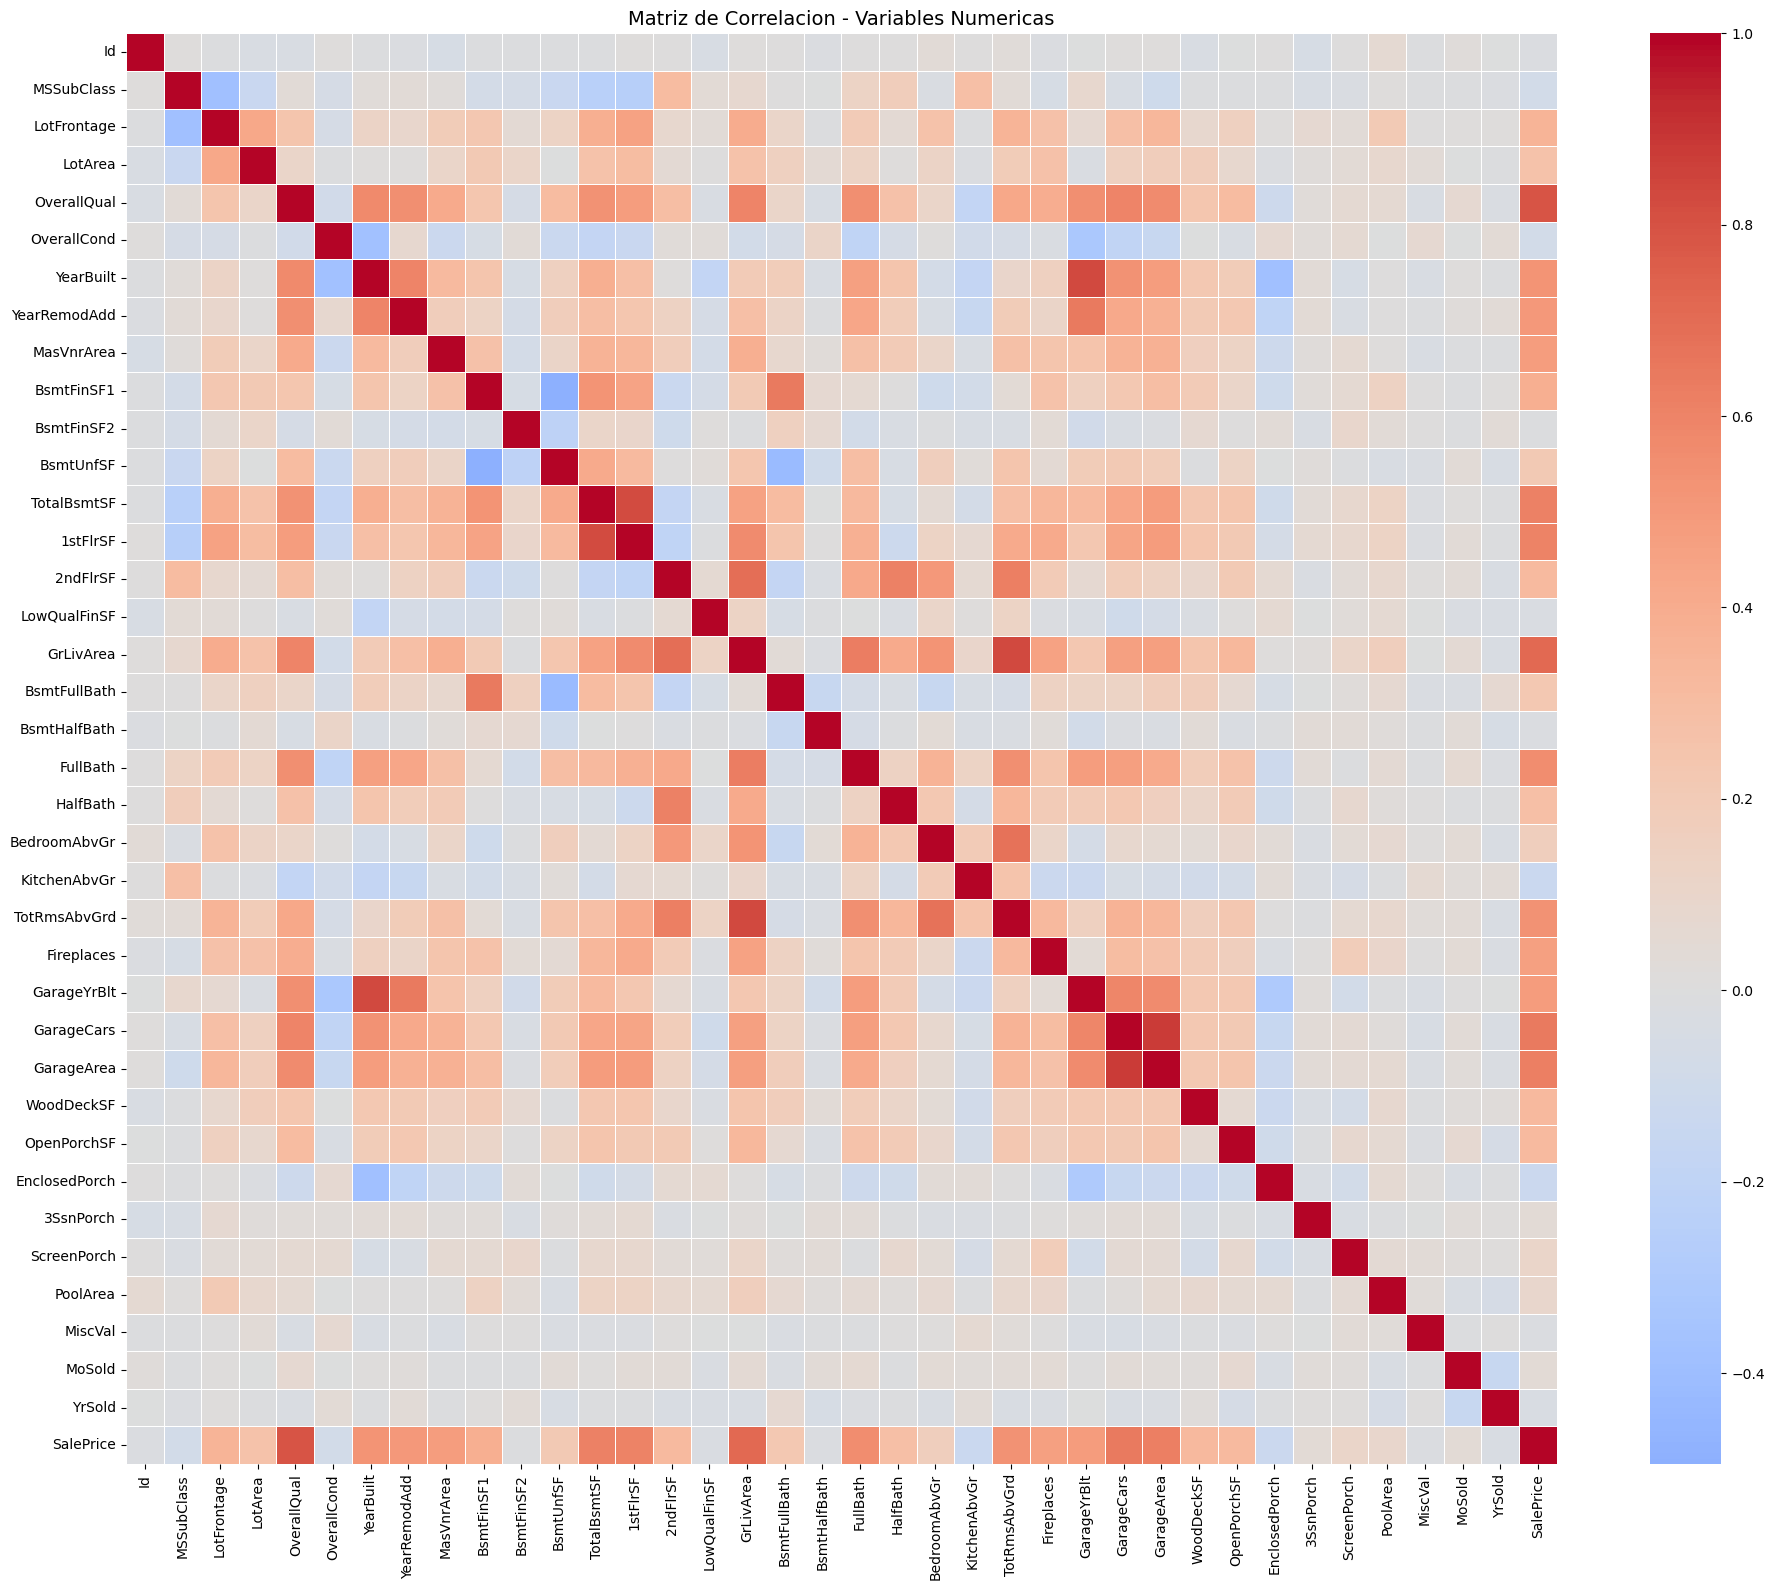

In [95]:
# ============================================
# MATRIZ DE CORRELACION (HEATMAP)
# ============================================

# Calculamos la correlacion solo para variables numericas
# La correlacion de Pearson mide la relacion lineal entre variables (-1 a 1)
correlation_matrix = ds_base_train.select_dtypes(include=[np.number]).corr()

# Visualizamos con un heatmap
# Los colores mas intensos indican mayor correlacion (positiva o negativa)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=False,  # Sin numeros para que sea mas legible
            cmap='coolwarm',  # Azul = negativa, Rojo = positiva
            center=0,
            square=True,
            linewidths=0.5)
plt.title('Matriz de Correlacion - Variables Numericas', fontsize=14)
plt.tight_layout()
plt.show()

TOP 10 VARIABLES MAS CORRELACIONADAS CON SALEPRICE

Correlaciones POSITIVAS (a mayor valor, mayor precio):
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101

Correlaciones NEGATIVAS (a mayor valor, menor precio):
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907


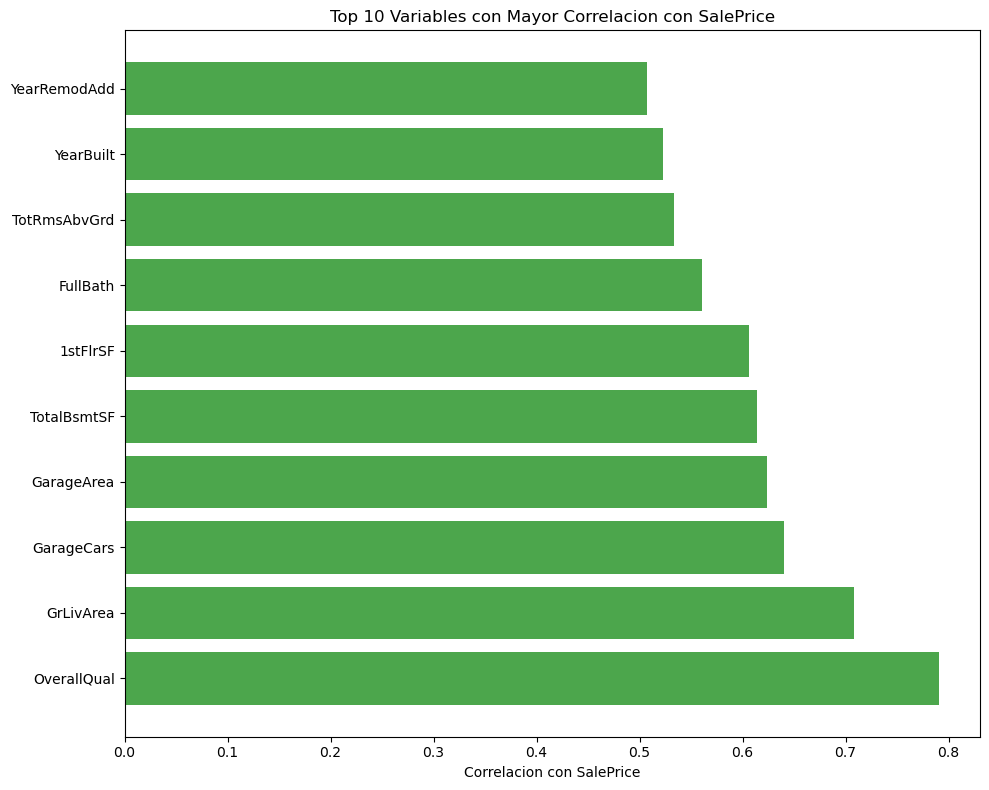

In [96]:
# ============================================
# TOP 10 VARIABLES MAS CORRELACIONADAS CON SALEPRICE
# ============================================

# Extraemos las correlaciones con SalePrice
# Esto nos dice que variables son mejores predictores del precio
correlaciones_target = correlation_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Top 10 correlaciones positivas
print("=" * 50)
print("TOP 10 VARIABLES MAS CORRELACIONADAS CON SALEPRICE")
print("=" * 50)
print("\nCorrelaciones POSITIVAS (a mayor valor, mayor precio):")
print(correlaciones_target.head(10).to_string())

print("\nCorrelaciones NEGATIVAS (a mayor valor, menor precio):")
print(correlaciones_target.tail(5).to_string())

# Visualizacion de las top 10
fig, ax = plt.subplots(figsize=(10, 8))
top_10 = correlaciones_target.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10.values]
ax.barh(top_10.index, top_10.values, color=colors, alpha=0.7)
ax.set_xlabel('Correlacion con SalePrice')
ax.set_title('Top 10 Variables con Mayor Correlacion con SalePrice')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

# Analisis de Multicolinealidad (VIF)

La multicolinealidad ocurre cuando dos o mas variables predictoras estan altamente correlacionadas entre si.
Esto puede causar problemas en modelos de regresion lineal:
- Coeficientes inestables
- Dificultad para interpretar la importancia de cada variable

**VIF (Variance Inflation Factor):**
- VIF = 1: No hay multicolinealidad
- VIF entre 1-5: Multicolinealidad moderada (aceptable)
- VIF > 5: Multicolinealidad alta (considerar eliminar la variable)
- VIF > 10: Multicolinealidad muy alta (problematico)

In [97]:
# ============================================
# CALCULO DE VIF (Variance Inflation Factor)
# ============================================

# Para calcular VIF necesitamos:
# 1. Solo variables numericas
# 2. Sin valores nulos
# 3. Sin la variable objetivo (SalePrice)

# Seleccionamos variables numericas excluyendo Id y SalePrice
cols_for_vif = ds_base_train.select_dtypes(include=[np.number]).columns.tolist()
cols_for_vif = [col for col in cols_for_vif if col not in ['Id', 'SalePrice']]

# Creamos un DataFrame sin nulos para el calculo de VIF
# Usamos dropna() ya que VIF no funciona con valores faltantes
df_vif = ds_base_train[cols_for_vif].dropna()

print(f"Variables para VIF: {len(cols_for_vif)}")
print(f"Filas sin nulos: {len(df_vif)} de {len(ds_base_train)}")

# Calculamos VIF para cada variable
# VIF mide cuanto aumenta la varianza de un coeficiente debido a multicolinealidad
vif_data = pd.DataFrame()
vif_data['Variable'] = cols_for_vif
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(cols_for_vif))]

# Ordenamos por VIF de mayor a menor
vif_data = vif_data.sort_values('VIF', ascending=False)

# Clasificamos por nivel de multicolinealidad
vif_data['Estado'] = vif_data['VIF'].apply(
    lambda x: 'MUY ALTA (>10)' if x > 10 else ('ALTA (5-10)' if x > 5 else 'OK (<5)')
)

print("\n" + "=" * 60)
print("ANALISIS DE MULTICOLINEALIDAD (VIF)")
print("=" * 60)
print("\n", vif_data.to_string(index=False))

# Resumen
print("\n" + "=" * 60)
print("RESUMEN")
print("=" * 60)
print(f"Variables con VIF > 10 (muy alta): {len(vif_data[vif_data['VIF'] > 10])}")
print(f"Variables con VIF 5-10 (alta): {len(vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)])}")
print(f"Variables con VIF < 5 (aceptable): {len(vif_data[vif_data['VIF'] <= 5])}")

Variables para VIF: 36
Filas sin nulos: 1121 de 1460

ANALISIS DE MULTICOLINEALIDAD (VIF)

      Variable          VIF         Estado
   BsmtFinSF2          inf MUY ALTA (>10)
    BsmtUnfSF          inf MUY ALTA (>10)
    GrLivArea          inf MUY ALTA (>10)
 LowQualFinSF          inf MUY ALTA (>10)
     2ndFlrSF          inf MUY ALTA (>10)
     1stFlrSF          inf MUY ALTA (>10)
  TotalBsmtSF          inf MUY ALTA (>10)
   BsmtFinSF1          inf MUY ALTA (>10)
  GarageYrBlt 26809.248170 MUY ALTA (>10)
       YrSold 25289.615273 MUY ALTA (>10)
    YearBuilt 24665.810992 MUY ALTA (>10)
 YearRemodAdd 24504.644733 MUY ALTA (>10)
 TotRmsAbvGrd    83.647906 MUY ALTA (>10)
  OverallQual    73.080715 MUY ALTA (>10)
  OverallCond    49.642685 MUY ALTA (>10)
 KitchenAbvGr    42.038152 MUY ALTA (>10)
   GarageCars    39.801166 MUY ALTA (>10)
   GarageArea    35.173809 MUY ALTA (>10)
 BedroomAbvGr    33.810414 MUY ALTA (>10)
     FullBath    28.744192 MUY ALTA (>10)
  LotFrontage    17.312995

/opt/anaconda3/envs/ml_proyect/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


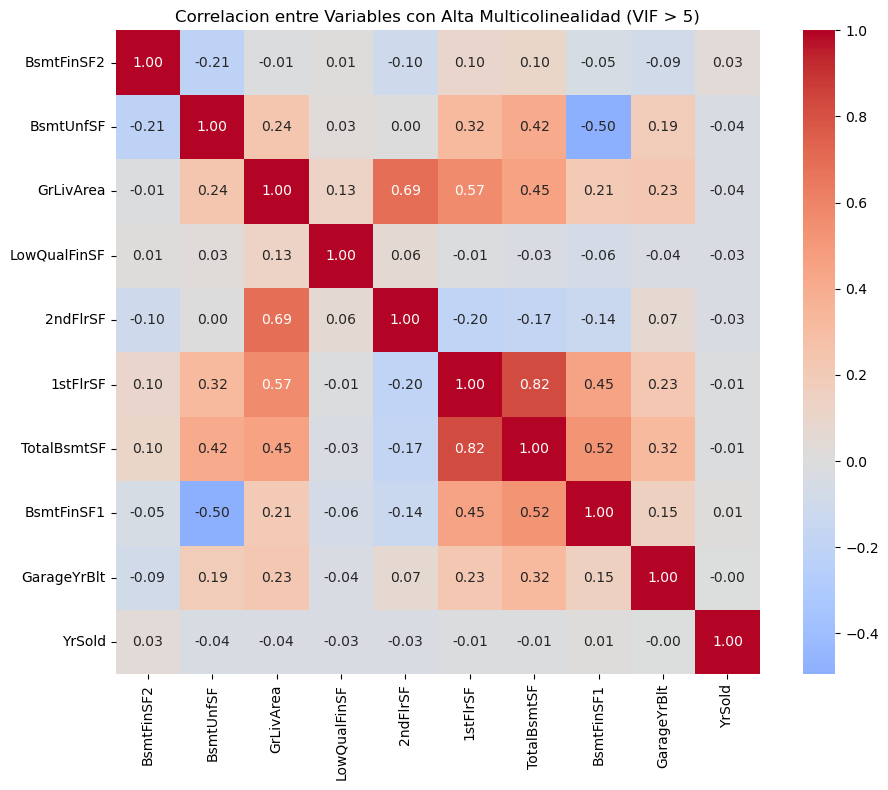

In [98]:
# ============================================
# VISUALIZACION DE VARIABLES CON ALTA MULTICOLINEALIDAD
# ============================================

# Mostramos las correlaciones entre las variables con VIF mas alto
# Esto nos ayuda a entender por que tienen multicolinealidad

# Tomamos las variables con VIF > 5
vars_alta_multicolinealidad = vif_data[vif_data['VIF'] > 5]['Variable'].tolist()[:10]

if len(vars_alta_multicolinealidad) > 1:
    # Matriz de correlacion solo para estas variables
    corr_alta = ds_base_train[vars_alta_multicolinealidad].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_alta, 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm', 
                center=0,
                square=True)
    plt.title('Correlacion entre Variables con Alta Multicolinealidad (VIF > 5)')
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables con VIF > 5 para mostrar correlaciones")

# Pipeline de Preprocesamiento

En esta seccion creamos un pipeline simple para preparar los datos para el modelo:

1. **Identificar columnas**: Separar numericas y categoricas
2. **Eliminar duplicados**: Verificar si hay filas duplicadas
3. **Imputar nulos**: 
   - Numericas: mediana (robusto a outliers)
   - Categoricas: valor "Missing" o moda
4. **One-Hot Encoding**: Convertir categoricas a numericas

In [99]:
# ============================================
# PASO 1: IDENTIFICAR COLUMNAS NUMERICAS Y CATEGORICAS
# ============================================

# Excluimos Id (identificador) y SalePrice (variable objetivo)
# Estas no deben ser parte del preprocesamiento de features

# Variables numericas para el modelo (excluyendo Id y SalePrice)
numeric_features = ds_base_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Id', 'SalePrice']]

# Variables categoricas para el modelo
categorical_features = ds_base_train.select_dtypes(include=['object']).columns.tolist()

print("=" * 60)
print("IDENTIFICACION DE COLUMNAS PARA PREPROCESAMIENTO")
print("=" * 60)
print(f"\nVariables NUMERICAS ({len(numeric_features)}):")
print(numeric_features)
print(f"\nVariables CATEGORICAS ({len(categorical_features)}):")
print(categorical_features)

IDENTIFICACION DE COLUMNAS PARA PREPROCESAMIENTO

Variables NUMERICAS (36):
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Variables CATEGORICAS (43):
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electr

In [100]:
# ============================================
# PASO 2: VERIFICAR Y ELIMINAR DUPLICADOS
# ============================================

# Los duplicados pueden sesgar el modelo si hay filas repetidas
# Verificamos si existen filas duplicadas en el dataset

print("=" * 60)
print("VERIFICACION DE DUPLICADOS")
print("=" * 60)

# Contamos filas duplicadas (excluyendo Id que siempre es unico)
duplicados = ds_base_train.drop('Id', axis=1).duplicated().sum()
print(f"\nFilas duplicadas encontradas: {duplicados}")

if duplicados > 0:
    print(f"Eliminando {duplicados} filas duplicadas...")
    # Eliminamos duplicados manteniendo la primera ocurrencia
    ds_train = ds_base_train.drop_duplicates(subset=ds_base_train.columns.difference(['Id']), keep='first')
    print(f"Filas despues de eliminar duplicados: {len(ds_train)}")
else:
    print("No hay duplicados. El dataset esta limpio.")
    ds_train = ds_base_train.copy()

print(f"\nDimensiones finales: {ds_train.shape}")

VERIFICACION DE DUPLICADOS

Filas duplicadas encontradas: 0
No hay duplicados. El dataset esta limpio.

Dimensiones finales: (1460, 81)


In [101]:
# ============================================
# PASO 3: CREAR TRANSFORMERS PARA CADA TIPO DE VARIABLE
# ============================================

# Transformer para variables NUMERICAS:
# - SimpleImputer: Rellena valores nulos con la mediana
#   (la mediana es robusta a outliers, mejor que la media)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Imputamos con mediana
])

# Transformer para variables CATEGORICAS:
# - SimpleImputer: Rellena valores nulos con 'Missing' (valor constante)
# - OneHotEncoder: Convierte categorias a variables binarias (0/1)
#   - drop='first': Evita multicolinealidad perfecta (dummy variable trap)
#   - handle_unknown='ignore': Si hay categorias nuevas en test, las ignora
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Nulos -> 'Missing'
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

print("Transformers creados:")
print("- numeric_transformer: Imputa con mediana")
print("- categorical_transformer: Imputa con 'Missing' + One-Hot Encoding")

Transformers creados:
- numeric_transformer: Imputa con mediana
- categorical_transformer: Imputa con 'Missing' + One-Hot Encoding


In [102]:
# ============================================
# PASO 4: CREAR EL COLUMNTRANSFORMER COMPLETO
# ============================================

# ColumnTransformer aplica diferentes transformaciones a diferentes columnas
# Esto permite procesar numericas y categoricas de forma diferente en un solo paso

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      # Aplicar numeric_transformer a numeric_features
        ('cat', categorical_transformer, categorical_features)  # Aplicar categorical_transformer a categorical_features
    ],
    remainder='drop'  # Descartamos columnas no especificadas (Id)
)

print("ColumnTransformer creado!")
print(f"\n- Variables numericas a procesar: {len(numeric_features)}")
print(f"- Variables categoricas a procesar: {len(categorical_features)}")

ColumnTransformer creado!

- Variables numericas a procesar: 36
- Variables categoricas a procesar: 43


In [103]:
# ============================================
# PASO 5: APLICAR PREPROCESAMIENTO Y VERIFICAR RESULTADO
# ============================================

# Separamos features (X) y target (y)
X = ds_train.drop(['Id', 'SalePrice'], axis=1)
y = ds_train['SalePrice']

# Aplicamos el preprocesamiento
# fit_transform: Ajusta el transformer a los datos y los transforma
X_processed = preprocessor.fit_transform(X)

print("=" * 60)
print("RESULTADO DEL PREPROCESAMIENTO")
print("=" * 60)
print(f"\nDimensiones originales: {X.shape}")
print(f"Dimensiones despues de preprocesar: {X_processed.shape}")
print(f"  - Variables numericas: {len(numeric_features)}")
print(f"  - Variables categoricas convertidas a dummies: {X_processed.shape[1] - len(numeric_features)}")

# Verificamos que no hay nulos
print(f"\nValores nulos en X_processed: {np.isnan(X_processed).sum()}")

# Creamos un DataFrame con los datos preprocesados para visualizar
# Obtenemos los nombres de las columnas despues del one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
all_feature_names = numeric_features + cat_feature_names

print(f"\nTotal de features finales: {len(all_feature_names)}")

RESULTADO DEL PREPROCESAMIENTO

Dimensiones originales: (1460, 79)
Dimensiones despues de preprocesar: (1460, 260)
  - Variables numericas: 36
  - Variables categoricas convertidas a dummies: 224

Valores nulos en X_processed: 0

Total de features finales: 260


In [104]:
# ============================================
# VISUALIZACION DEL DATASET PREPROCESADO
# ============================================

# Convertimos a DataFrame para mejor visualizacion
df_processed = pd.DataFrame(X_processed, columns=all_feature_names)

print("=" * 60)
print("MUESTRA DEL DATASET PREPROCESADO")
print("=" * 60)
print(f"\nPrimeras 5 filas (primeras 10 columnas):")
print(df_processed.iloc[:5, :10])

print(f"\nEstadisticas descriptivas (variables numericas originales):")
print(df_processed[numeric_features[:5]].describe().round(2))

MUESTRA DEL DATASET PREPROCESADO

Primeras 5 filas (primeras 10 columnas):
   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0        60.0         65.0   8450.0          7.0          5.0     2003.0   
1        20.0         80.0   9600.0          6.0          8.0     1976.0   
2        60.0         68.0  11250.0          7.0          5.0     2001.0   
3        70.0         60.0   9550.0          7.0          5.0     1915.0   
4        60.0         84.0  14260.0          8.0          5.0     2000.0   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  
0        2003.0       196.0       706.0         0.0  
1        1976.0         0.0       978.0         0.0  
2        2002.0       162.0       486.0         0.0  
3        1970.0         0.0       216.0         0.0  
4        2000.0       350.0       655.0         0.0  

Estadisticas descriptivas (variables numericas originales):
       MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond
count      1460

# Resumen del Preprocesamiento

**Lo que hicimos:**
1. Identificamos 36 variables numericas y 43 categoricas
2. Verificamos y eliminamos duplicados (si existian)
3. Imputamos nulos:
   - Numericas: mediana
   - Categoricas: valor "Missing"
4. Aplicamos One-Hot Encoding a las categoricas (drop='first')

**Resultado:**
- Dataset listo para entrenar un modelo de regresion
- Sin valores nulos
- Todas las variables son numericas

**Proximo paso:**
- Entrenar un modelo de regresion lineal como baseline

# Regresion lineal simple

In [105]:
model_linearRegression = LinearRegression()
model_linearRegression.fit(df_processed, y)

print(f"intercept: {model_linearRegression.intercept_:.3f}")
print(f"Coefficient Exposure: {model_linearRegression.coef_[0]:.3f}")

intercept: -579843.748
Coefficient Exposure: -55.118


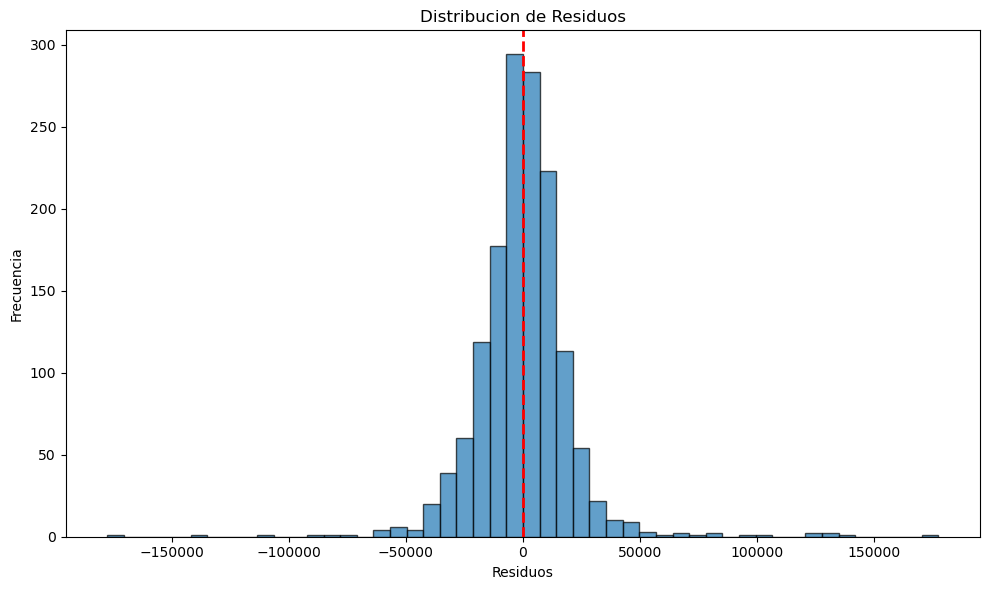

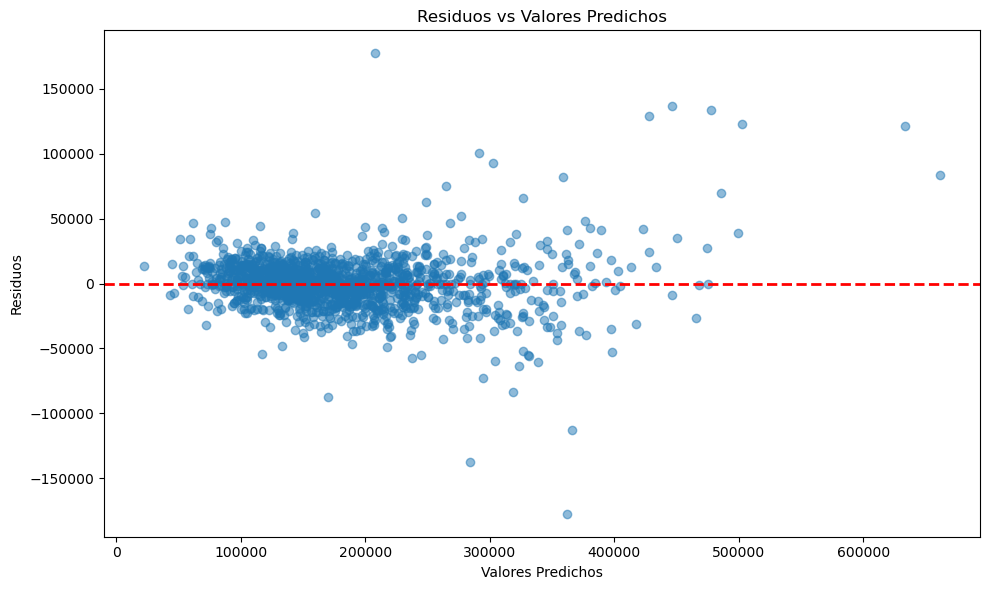

In [106]:
fitted_train = model_linearRegression.predict(df_processed)
residual_train = y - fitted_train

# ============================================
# DISTRIBUCION DE RESIDUOS
# ============================================

plt.figure(figsize=(10, 6))
plt.hist(residual_train, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribucion de Residuos')
plt.tight_layout()
plt.show()

# ============================================
# GRAFICO DE RESIDUOS
# ============================================

plt.figure(figsize=(10, 6))

# Residuos vs Valores Predichos
plt.scatter(fitted_train, residual_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.tight_layout()
plt.show()

In [107]:
# ============================================
# VALIDACION CRUZADA
# ============================================
from sklearn.model_selection import cross_val_score, KFold

# Configuramos K-Fold con 5 particiones
# shuffle=True mezcla los datos antes de dividir
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Aplicamos validacion cruzada
# Usamos neg_mean_squared_error porque sklearn maximiza (por eso es negativo)
cv_scores = cross_val_score(
    model_linearRegression,  # Modelo ya creado
    df_processed,            # Features preprocesadas
    y,                       # Target
    cv=kfold,
    scoring='neg_mean_squared_error'
)

# Convertimos a RMSE (raiz del error cuadratico medio)
rmse_scores = np.sqrt(-cv_scores)

print("=" * 50)
print("VALIDACION CRUZADA (5-Fold)")
print("=" * 50)
print(f"\nRMSE por fold: {rmse_scores.round(2)}")
print(f"\nRMSE Promedio: {rmse_scores.mean():,.2f}")
print(f"Desviacion Std: {rmse_scores.std():,.2f}")

# R² con validacion cruzada
cv_r2 = cross_val_score(
    model_linearRegression,
    df_processed,
    y,
    cv=kfold,
    scoring='r2'
)

print(f"\nR² por fold: {cv_r2.round(4)}")
print(f"R² Promedio: {cv_r2.mean():.4f}")
print(f"Desviacion Std: {cv_r2.std():.4f}")

VALIDACION CRUZADA (5-Fold)

RMSE por fold: [83088.77 28215.28 50926.93 34616.94 41568.05]

RMSE Promedio: 47,683.19
Desviacion Std: 19,241.61

R² por fold: [0.0999 0.8829 0.5306 0.8092 0.6694]
R² Promedio: 0.5984
Desviacion Std: 0.2769


In [108]:
model_linearRegression_ponderada = LinearRegression()
weights = 1 / y  # Inverso del precio
model_linearRegression_ponderada.fit(df_processed, y, sample_weight=weights)

y_pred_ponderado = model_linearRegression_ponderada.predict(df_processed)

print("=" * 50)
print("REGRESION LINEAL PONDERADA")
print("=" * 50)
print(f"Intercepto: {model_linearRegression_ponderada.intercept_:,.2f}")
print(f"Primeros 5 coeficientes: ")
for name, coef in zip(all_feature_names[:5], model_linearRegression_ponderada.coef_[:5]):
    print(f"  {name}: {coef:,.2f}")

REGRESION LINEAL PONDERADA
Intercepto: -434,787.35
Primeros 5 coeficientes: 
  MSSubClass: -40.62
  LotFrontage: 26.12
  LotArea: 0.71
  OverallQual: 5,852.07
  OverallCond: 4,932.66


In [109]:
from sklearn.metrics import r2_score, mean_squared_error

print("\n" + "=" * 50)
print("COMPARACION: NORMAL vs PONDERADO")
print("=" * 50)

# Metricas modelo normal
r2_normal = r2_score(y, fitted_train)
rmse_normal = np.sqrt(mean_squared_error(y, fitted_train))

# Metricas modelo ponderado
r2_pond = r2_score(y, y_pred_ponderado)
rmse_pond = np.sqrt(mean_squared_error(y, y_pred_ponderado))

print(f"\n{'Metrica':<15} {'Normal':<15} {'Ponderado':<15}")
print("-" * 45)
print(f"{'R²':<15} {r2_normal:<15.4f} {r2_pond:<15.4f}")
print(f"{'RMSE':<15} {rmse_normal:<15,.2f} {rmse_pond:<15,.2f}")


COMPARACION: NORMAL vs PONDERADO

Metrica         Normal          Ponderado      
---------------------------------------------
R²              0.9332          0.9262         
RMSE            20,517.84       21,567.69      


In [ ]:
# ============================================
# ELIMINAR VARIABLES CON ALTA MULTICOLINEALIDAD
# ============================================

# Eliminamos variables numericas con VIF > 10 (muy alta multicolinealidad)
vars_eliminar = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()

print("=" * 60)
print("VARIABLES A ELIMINAR POR ALTA MULTICOLINEALIDAD (VIF > 10)")
print("=" * 60)
print(f"\nVariables eliminadas: {len(vars_eliminar)}")
print(vars_eliminar)

# Creamos lista de variables numericas SIN multicolinealidad
numeric_features_clean = [col for col in numeric_features if col not in vars_eliminar]

print(f"\nVariables numericas originales: {len(numeric_features)}")
print(f"Variables numericas sin multicolinealidad: {len(numeric_features_clean)}")

In [ ]:
# ============================================
# PIPELINE SIN MULTICOLINEALIDAD
# ============================================

# Creamos segundo preprocessor con variables limpias
preprocessor_clean = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_clean),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Aplicamos preprocesamiento
X_processed_clean = preprocessor_clean.fit_transform(X)

# Nombres de columnas
cat_encoder_clean = preprocessor_clean.named_transformers_['cat'].named_steps['onehot']
cat_feature_names_clean = cat_encoder_clean.get_feature_names_out(categorical_features).tolist()
all_feature_names_clean = numeric_features_clean + cat_feature_names_clean

# DataFrame limpio
df_processed_clean = pd.DataFrame(X_processed_clean, columns=all_feature_names_clean)

print("=" * 60)
print("COMPARACION DE PIPELINES")
print("=" * 60)
print(f"\n{'Pipeline':<25} {'Vars Num':<12} {'Total Features':<15}")
print("-" * 52)
print(f"{'Original':<25} {len(numeric_features):<12} {X_processed.shape[1]:<15}")
print(f"{'Sin Multicolinealidad':<25} {len(numeric_features_clean):<12} {X_processed_clean.shape[1]:<15}")

In [ ]:
# ============================================
# COMPARAR MODELOS
# ============================================

# Modelo con todas las variables
model_full = LinearRegression()
model_full.fit(df_processed, y)
pred_full = model_full.predict(df_processed)

# Modelo sin multicolinealidad
model_clean = LinearRegression()
model_clean.fit(df_processed_clean, y)
pred_clean = model_clean.predict(df_processed_clean)

# Comparar
print("=" * 60)
print("COMPARACION DE MODELOS")
print("=" * 60)
print(f"\n{'Modelo':<25} {'R²':<10} {'RMSE':<15}")
print("-" * 50)
print(f"{'Con todas las variables':<25} {r2_score(y, pred_full):<10.4f} {np.sqrt(mean_squared_error(y, pred_full)):<15,.2f}")
print(f"{'Sin multicolinealidad':<25} {r2_score(y, pred_clean):<10.4f} {np.sqrt(mean_squared_error(y, pred_clean)):<15,.2f}")